In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import NullFormatter
import seaborn as sns
import pandas as pd
import os

sns.set_style('white')
sns.set_context('poster')


# Solutions: Unsupervised Learning

For some introduction, please see notebook 1. This notebook assumes some acquintance with the scikit-learn API. Much of the material here is adapted from [Python Data Science Handbook](https://github.com/jakevdp/PythonDataScienceHandbook) by Jake VanderPlas and a [workshop at SciPY 2016](https://github.com/amueller/scipy-2016-sklearn) by Sebastian Raschka and Andreas Mueller.

## Data preparation: standardization, normalization and feature engineering

In order to illustrate the purpose and workings of data preparation and standardization, we will use the commonly used iris data set. If you need some background about the data set, see: https://archive.ics.uci.edu/ml/datasets/iris


In [2]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

iris = load_iris()
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, random_state=0)
print(X_train.shape)

(112, 4)


Verify that the features of this data set are not centered around zero and that their standard deviations aren't one. Also, graphically investigate the data. If you don't know about seaborn yet, this may be a good point to check it out. It is a package for "statistical graphing" and has some useful functionality for visualization of multivariate data sets. Have a look at the gallery for inspiration, if you need any: http://seaborn.pydata.org/examples/ Here, pairplot may be a nice function.

What does this data set look like?

In [3]:
print("mean : %s " % X_train.mean(axis=0))
print("standard deviation : %s " % X_train.std(axis=0))

mean : [ 5.88660714  3.05178571  3.79642857  1.22232143] 
standard deviation : [ 0.86741565  0.43424445  1.79264014  0.77916047] 


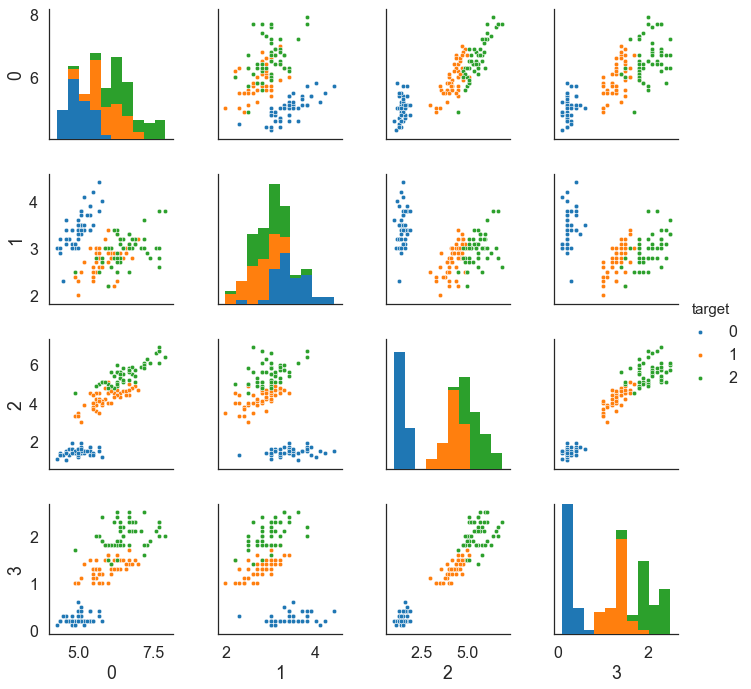

In [4]:
# I'll make this a dataframe, because seaborn's pairplot likes that, feel free to follow your own path
targetdf = pd.DataFrame(data=iris.target, columns=['target'])
irisdf = pd.DataFrame(data=iris.data)
irisdf = irisdf.merge(targetdf, left_index=True, right_index=True)
sns.pairplot(irisdf, vars=[0, 1, 2, 3], hue='target', plot_kws={'s':20});

Train (on the training data) and score (on the test data) a logistic regressor that predicts the correct label for the iris data set.

In [5]:
from sklearn.linear_model import LogisticRegression
reg = LogisticRegression()
reg.fit(X_train, y_train)
reg.score(X_test, y_test)

0.86842105263157898

Now subtract the mean and divide out the standard deviation of all features by hand, as well as through the sklearn functionality and see if you can get to the same results. After that, try the fit again and evaluate the results!


In [6]:
# What do you do with test? Averages and stds need not be well defined in a test set, 
# as they can consist of just one data point. USe average and std of training data!
# This is a recipe that will always work
# I do these first, because the train set will change...
X_test -= np.mean(X_train, axis=0)
X_test /= np.std(X_train, axis=0)

X_train -= np.mean(X_train, axis=0)
X_train /= np.std(X_train, axis=0)

# Possible in one step as well:
# X_test = (X_test - X_train.mean(axis=0)) / X_train.std(axis=0)
# X_train = (X_train - X_train.mean(axis=0)) / X_train.std(axis=0)

In [7]:
print("mean : %s " % X_train.mean(axis=0))
print("standard deviation : %s " % X_train.std(axis=0))
print("----------")
print("mean : %s " % X_test.mean(axis=0))
print("standard deviation : %s " % X_test.std(axis=0))
print("----------")
print("Note that the mean and standard deviation of the test are not zero and one, repsectively.")

mean : [  1.23908820e-15  -5.05547984e-17   7.13714802e-17   2.57730345e-17] 
standard deviation : [ 1.  1.  1.  1.] 
----------
mean : [-0.19692712  0.0201283  -0.08315118 -0.11983932] 
standard deviation : [ 0.77268842  0.98063732  0.91980597  0.89642628] 
----------
Note that the mean and standard deviation of the test are not zero and one, repsectively.


In [8]:
reg.fit(X_train, y_train)
reg.score(X_test, y_test)

0.81578947368421051

Did this increase the goodness of fit? Can you explain? Can you find an example where it would be wise to scale the data?

It did not increase the goodness of fit, but it didn't get too much worse either. Dimensions along all axes are comparable, and along the features that seperate groups the strongest, the distances were bigger, which is corrected out by the standardization. These features have physical meaning, and a scaling may not even be appropriate here.

In case of a data set with ages in years and gender, e.g., distances between one gender and the next would normally be 1, the same difference as an age difference of 1. In most applications, one would scale the ages such that the spread in ages becomes comparable to that in genders. 

In order to illustrate a case where scaling is good practice, look at the Titanic data set again, do the imputation and apply sklearn.preprocessing's StandardScaler. Consequenstly, use a k-nearest neighbor classifier on the original as well as the scaled data. 

In [9]:
titanic = pd.read_csv(os.path.join('data', 'titanic3.csv'))
labels = titanic.survived.values
features = titanic[['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked']]
features_dummies = pd.get_dummies(features, columns=['pclass', 'sex', 'embarked'])
features_dummies.head()

,age,sibsp,parch,fare,pclass_1,pclass_2,pclass_3,sex_female,sex_male,embarked_C,embarked_Q,embarked_S
0,29.0000,0,0,211.3375,1,0,0,1,0,0,0,1
1,0.9167,1,2,151.5500,1,0,0,0,1,0,0,1
2,2.0000,1,2,151.5500,1,0,0,1,0,0,0,1
3,30.0000,1,2,151.5500,1,0,0,0,1,0,0,1
4,25.0000,1,2,151.5500,1,0,0,1,0,0,0,1


In [10]:
from sklearn.neighbors import KNeighborsClassifier
cf = KNeighborsClassifier()

from sklearn.preprocessing import Imputer
imp = Imputer()
decent_data = imp.fit_transform(features_dummies)

from sklearn.preprocessing import  StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(decent_data)

cf.fit(decent_data, titanic.survived)
print("Score without scaling:", cf.score(decent_data, titanic.survived))

cf.fit(scaled_data, titanic.survived)
print("Score with scaling:", cf.score(scaled_data, titanic.survived))



Score without scaling: 0.795263559969
Score with scaling: 0.850267379679


## Dimensionality reduction and feature extraction

A simple data set to illustrate the workings.

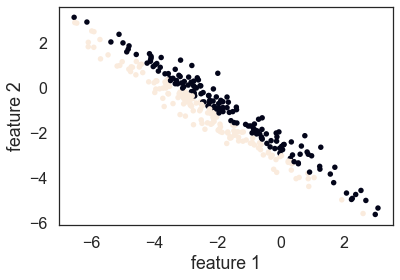

In [11]:
rnd = np.random.RandomState(5)
X_ = rnd.normal(size=(300, 2))
X_blob = np.dot(X_, rnd.normal(size=(2, 2))) + rnd.normal(size=2)
y = X_[:, 0] > 0
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y, linewidths=0, s=30)
plt.xlabel("feature 1")
plt.ylabel("feature 2");

There is a clear linear relationship between these variables. Find it, subtract it and plot the results.

Shape: (300, 2)
Weight coefficients:  [-0.85152914]
y-axis intercept:  -2.79083718155


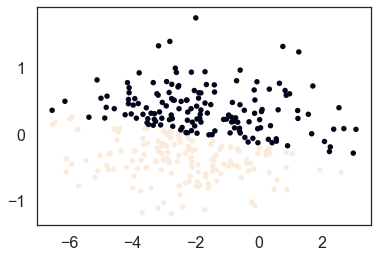

In [12]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
print("Shape:", np.shape(X_blob))
regressor.fit(X_blob[:,0].reshape(len(X_blob),1), X_blob[:,1])                                  # Fit the model
print('Weight coefficients: ', regressor.coef_)      # coefficients are multiplied with the indepent variable
print('y-axis intercept: ', regressor.intercept_)    # The intercept is an extra to this model
plt.scatter(X_blob[:,0], X_blob[:,1] - regressor.intercept_ - regressor.coef_*X_blob[:,0], c=y, linewidths=0, s=30)

Now try a PCA analysis on the same data set and plot the first and second components against one another. 
- How does this compare to the trend-subtracted version above? Can you understand this?
- Why would one need PCA if this is so similar?

In [13]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(X_blob)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

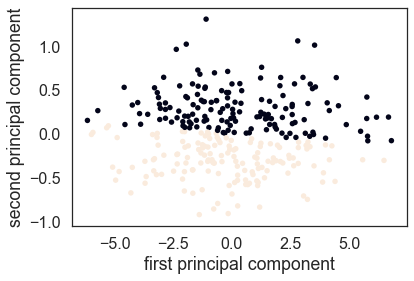

In [14]:
X_pca = pca.transform(X_blob)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, linewidths=0, s=30)
plt.xlabel("first principal component")
plt.ylabel("second principal component");

As an exercise, standardize this data set and and repeat the PCA. What is the difference? Does it make a difference whether you use a standard scaler or a minmax scaler? 

See the solutions about standardization above. For the rest it should be all the same. Would have made a difference if the original extentof the data was less similar. The choice between standard scaling and minmax scaling is only relevant if the data is not distributed "nicely" among the full extent of the axes (think of: highly asymmetric, outliers, etc.).

In the iris data set above, how many of the principal components would you need to take along, if you were to reduce dimensionality that way? How do the "important" principal components relate to the original features?


In [15]:
pca.fit(iris.data)
print(pca.explained_variance_ratio_)
pca.inverse_transform([1,0,0,0])

[ 0.92461621  0.05301557  0.01718514  0.00518309]


array([ 6.20492301,  2.97173111,  4.61523877,  1.55751059])

It apears that 92% of the variance is explained by the first principle component. Therefore, taking only one component into account would not result in losing a whole lot of information. The inverse transform shows how a vector along the first principal component looks in the original data space. It depends most strongly on components 0 and 2, but does not ignore any of the original features in the data.

## Manifold learning: non-linear features

Very often, features of a data set in many dimensions do not scale linearly with one another and therefore simple axis rotations like PCA may not be sufficient extract useful features. Manifold learning techniques are developed to find irregularly shaped manifolds in high-dimensional data sets and to "unfold" these into a lower-dimensional space.

For the sake of consistency with the world, we will use the S-curve data creator that comes with sci-kit-learn:

In [16]:
from sklearn import manifold, datasets, decomposition


In [17]:
n_points = 1000
X, color = datasets.samples_generator.make_s_curve(n_points, random_state=0)
n_neighbors = 10
n_components = 2

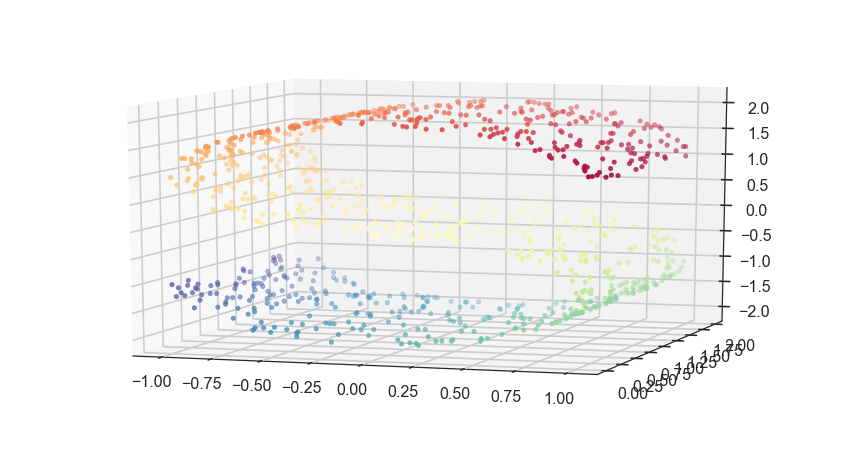

In [18]:
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=color, cmap=plt.cm.Spectral)
ax.view_init(10, -72)


Just because you know how to do it now, have a look what PCA would do with this data set. Run it, plot it and describe it in words.

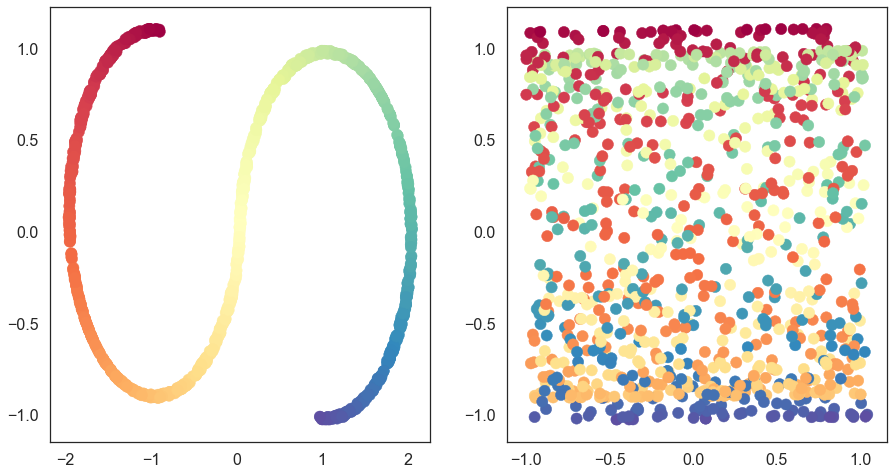

In [19]:
pca = decomposition.PCA()
pcas = pca.fit_transform(X)
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(121)
plt.scatter(pcas[:, 0], pcas[:, 1], c=color, cmap=plt.cm.Spectral)
ax = fig.add_subplot(122)
plt.scatter(pcas[:, 2], pcas[:, 1], c=color, cmap=plt.cm.Spectral)



You have probably heard about two algorithms for manifold learning: Isomap and t-SNE. There are a whole lot more. In sklearn.manifold.LocallyLinearEmbedding, there are a few methods for locally linear embedding algorithms. Furthermore, there are spectral embedding and MDS (multi-dimensional scaling).

Try a few of these. Run them, and plot the main two components against one another and investigate the results. Also: note the differences in run time. 

The solution below shows an overview of many, pick whatever you like.

standard: 0.36 sec
ltsa: 0.57 sec
hessian: 0.86 sec
modified: 0.63 sec
Isomap: 0.64 sec
MDS: 3 sec
SpectralEmbedding: 0.24 sec
t-SNE: 27 sec


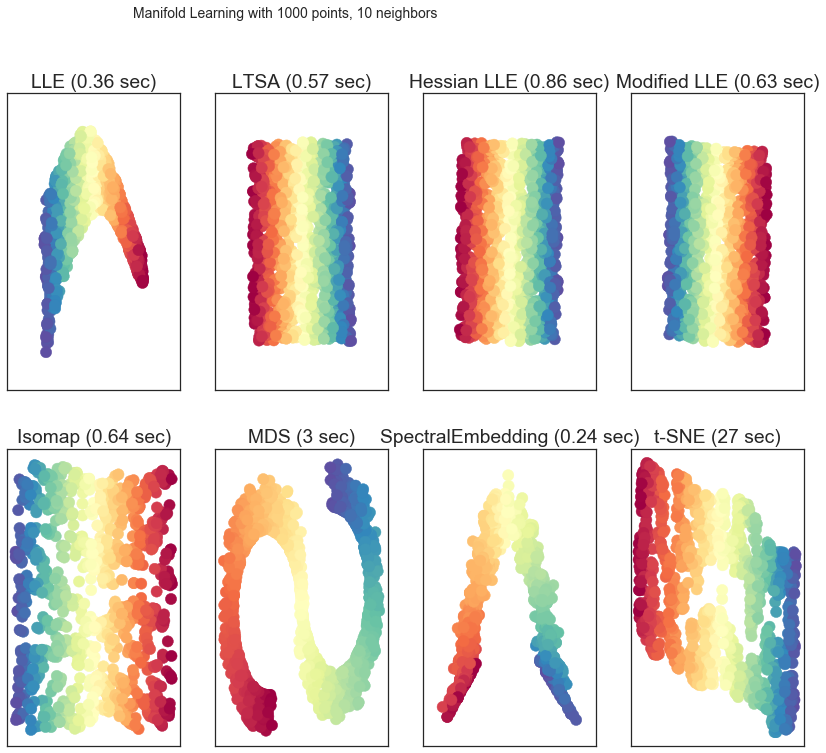

In [20]:
fig = plt.figure(figsize=(18, 12))
plt.suptitle("Manifold Learning with %i points, %i neighbors"
             % (1000, n_neighbors), fontsize=14)




methods = ['standard', 'ltsa', 'hessian', 'modified']
labels = ['LLE', 'LTSA', 'Hessian LLE', 'Modified LLE']

# For timing purposes, import timing functionality
from time import time


for i, method in enumerate(methods):
    t0 = time()
    Y = manifold.LocallyLinearEmbedding(n_neighbors, n_components,
                                        eigen_solver='auto',
                                        method=method).fit_transform(X)
    t1 = time()
    print("%s: %.2g sec" % (methods[i], t1 - t0))

    ax = fig.add_subplot(252 + i)
    plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
    plt.title("%s (%.2g sec)" % (labels[i], t1 - t0))
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    plt.axis('tight')

t0 = time()
Y = manifold.Isomap(n_neighbors, n_components).fit_transform(X)
t1 = time()
print("Isomap: %.2g sec" % (t1 - t0))
ax = fig.add_subplot(257)
plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
plt.title("Isomap (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')


t0 = time()
mds = manifold.MDS(n_components, max_iter=100, n_init=1)
Y = mds.fit_transform(X)
t1 = time()
print("MDS: %.2g sec" % (t1 - t0))
ax = fig.add_subplot(258)
plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
plt.title("MDS (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')


t0 = time()
se = manifold.SpectralEmbedding(n_components=n_components,
                                n_neighbors=n_neighbors)
Y = se.fit_transform(X)
t1 = time()
print("SpectralEmbedding: %.2g sec" % (t1 - t0))
ax = fig.add_subplot(259)
plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
plt.title("SpectralEmbedding (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')

t0 = time()
tsne = manifold.TSNE(n_components=n_components, init='pca', random_state=0)
Y = tsne.fit_transform(X)
t1 = time()
print("t-SNE: %.2g sec" % (t1 - t0))
ax = fig.add_subplot(2, 5, 10)
plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
plt.title("t-SNE (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight');


You may by now have developed a certain preference for some of these models. Remember, however, that this was done using one particular data set and performance of the different algorithms may depend on the specifics of your data set. In order to quickly investigate that, let us create two S-curves right next to each other and repeat what you did before. How are things looking now?

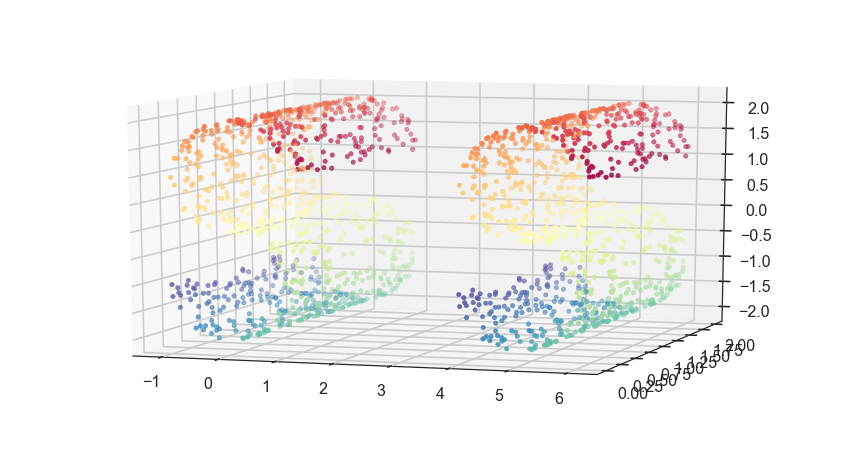

In [21]:
X1 = np.array([X[:, 0]+5, X[:, 1], X[:, 2]]).T
Z = np.concatenate([X, X1])
zcolor = np.concatenate([color, color])

fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Z[:, 0], Z[:, 1], Z[:, 2], c=zcolor, cmap=plt.cm.Spectral)
ax.view_init(10, -72)


standard: 0.71 sec
ltsa: 0.99 sec
hessian: 1.8 sec
modified: 1.2 sec
Isomap: 1.3 sec
MDS: 11 sec


/home/marcel/anaconda3/lib/python3.6/site-packages/sklearn/manifold/spectral_embedding_.py:234: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


SpectralEmbedding: 0.8 sec
t-SNE: 42 sec


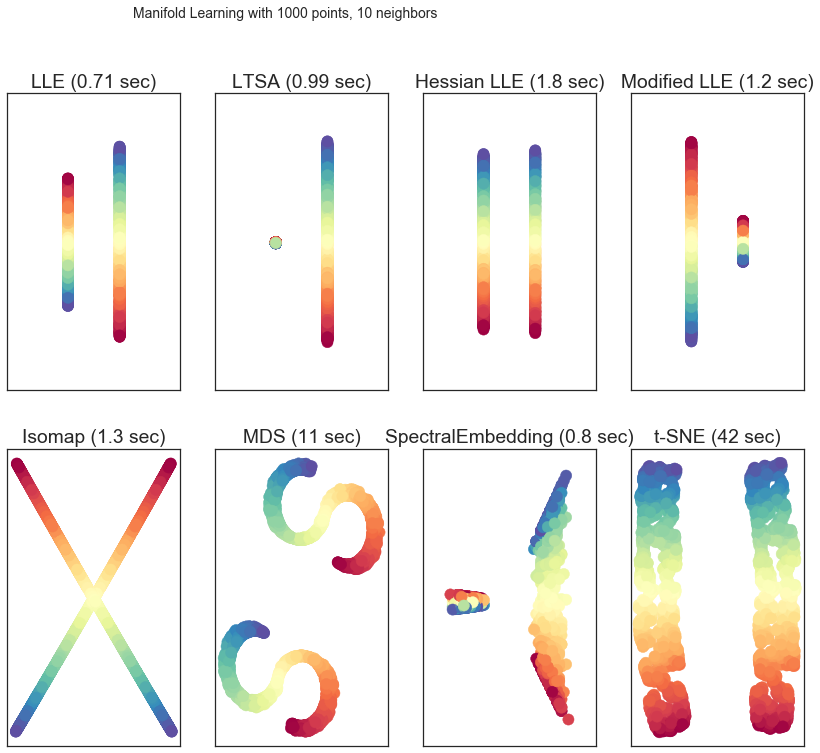

In [22]:
fig = plt.figure(figsize=(18, 12))
plt.suptitle("Manifold Learning with %i points, %i neighbors"
             % (1000, n_neighbors), fontsize=14)




methods = ['standard', 'ltsa', 'hessian', 'modified']
labels = ['LLE', 'LTSA', 'Hessian LLE', 'Modified LLE']

for i, method in enumerate(methods):
    t0 = time()
    Y = manifold.LocallyLinearEmbedding(n_neighbors, n_components,
                                        eigen_solver='auto',
                                        method=method).fit_transform(Z)
    t1 = time()
    print("%s: %.2g sec" % (methods[i], t1 - t0))

    ax = fig.add_subplot(252 + i)
    plt.scatter(Y[:, 0], Y[:, 1], c=zcolor, cmap=plt.cm.Spectral)
    plt.title("%s (%.2g sec)" % (labels[i], t1 - t0))
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    plt.axis('tight')

t0 = time()
Y = manifold.Isomap(n_neighbors, n_components).fit_transform(Z)
t1 = time()
print("Isomap: %.2g sec" % (t1 - t0))
ax = fig.add_subplot(257)
plt.scatter(Y[:, 0], Y[:, 1], c=zcolor, cmap=plt.cm.Spectral)
plt.title("Isomap (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')


t0 = time()
mds = manifold.MDS(n_components, max_iter=100, n_init=1)
Y = mds.fit_transform(Z)
t1 = time()
print("MDS: %.2g sec" % (t1 - t0))
ax = fig.add_subplot(258)
plt.scatter(Y[:, 0], Y[:, 1], c=zcolor, cmap=plt.cm.Spectral)
plt.title("MDS (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')


t0 = time()
se = manifold.SpectralEmbedding(n_components=n_components,
                                n_neighbors=n_neighbors)
Y = se.fit_transform(Z)
t1 = time()
print("SpectralEmbedding: %.2g sec" % (t1 - t0))
ax = fig.add_subplot(259)
plt.scatter(Y[:, 0], Y[:, 1], c=zcolor, cmap=plt.cm.Spectral)
plt.title("SpectralEmbedding (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')

t0 = time()
tsne = manifold.TSNE(n_components=n_components, init='pca', random_state=0)
Y = tsne.fit_transform(Z)
t1 = time()
print("t-SNE: %.2g sec" % (t1 - t0))
ax = fig.add_subplot(2, 5, 10)
plt.scatter(Y[:, 0], Y[:, 1], c=zcolor, cmap=plt.cm.Spectral)
plt.title("t-SNE (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight');


As always, experiment! Investigate your data graphically and play around with options!

## Clustering

Finding clusters by eye in a low-dimensional space is often easy. Making a computer do just that is already less trivial, let alone trying to do so in a higher dimensional space.


### k-means
We start out simple. Using make_blobs we will make, well, blobs. Let's cluster!

(100, 2)


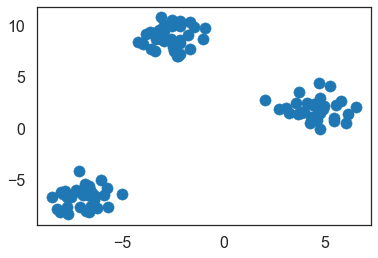

In [23]:
from sklearn.datasets import make_blobs

X, y = make_blobs(random_state=42)
print(X.shape)

plt.scatter(X[:, 0], X[:, 1]);

I think it's easy enough to cluster these by eye and to determine how many clusters one would need. That's a good thing, because most clustering algorithms need to be told how many clusters they need to find.

Do a k-means clustering on this data set. Start with the obvious 3 clusters, but also vary that. As always, plot your results, for example colored by cluster label.

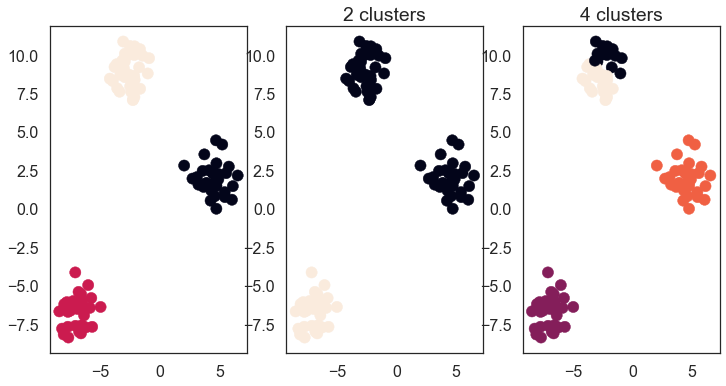

In [24]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=42)
labels = kmeans.fit_predict(X)
plt.figure(figsize=(12,6))
plt.subplot(131)
plt.scatter(X[:, 0], X[:, 1], c=labels);

kmeans = KMeans(n_clusters=2, random_state=42)
labels = kmeans.fit_predict(X)
plt.subplot(132)
plt.scatter(X[:, 0], X[:, 1], c=labels);
plt.title("2 clusters");

kmeans = KMeans(n_clusters=4, random_state=42)
labels = kmeans.fit_predict(X)
plt.subplot(133)
plt.scatter(X[:, 0], X[:, 1], c=labels)
plt.title("4 clusters");


Interestingly, for the three-cluster case:

In [25]:
kmeans = KMeans(n_clusters=3, random_state=42)
labels = kmeans.fit_predict(X)
print(all(labels == y))
kmeans.score(X, y)

False


-171.91098459057724

Obviously, which of the clusters is cluster 1 and which is 2 is irrelevant, all that is relevant is that the same observations belong to the same cluster, not what it's label is. Invent a score that is label invariant!

sklearn also has a scoring for this: adjusted rand score: 

In [26]:
from sklearn.metrics import adjusted_rand_score

adjusted_rand_score(y, labels)

1.0

Let's investigate what happens when the spheres are less well separated and/or unequal in size. Use the following two sets of blobs and investigate what happens with two, three or four clusters. 

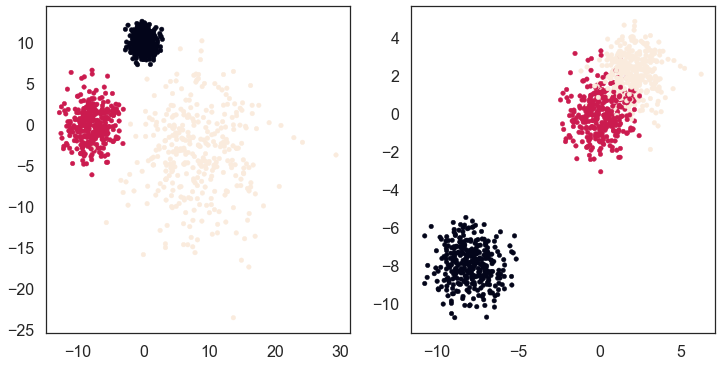

In [27]:
X1, y1 = make_blobs(random_state=101, cluster_std=[1, 2, 5], centers=[[0, 10],[-8, 0], [8,-4]], n_samples=1000, )
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.scatter(X1[:, 0], X1[:, 1], c=y1, s=20)
X2, y2 = make_blobs(random_state=101, centers=[[-8, -8],[0, 0], [2,2]], n_samples=1000, )
plt.subplot(122)
plt.scatter(X2[:, 0], X2[:, 1], c=y2, s=20);


Try what we tried before: k-means with 2, 3, 4 clusters and investigate the clusters it returns. Some insight might appear when you plot the cluster centers and look at the cluster boundaries.

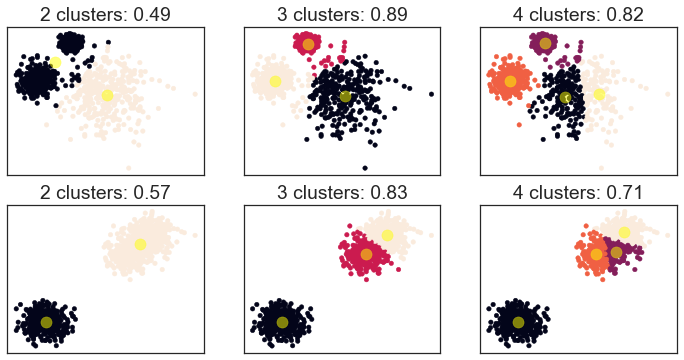

In [28]:
plt.figure(figsize=(12,6))
for i in range(6):
    if i<3: 
        X = X1
        y = y1
    else: 
        X = X2
        y = y2
    ncl = (i%3)+2
    kmeans = KMeans(n_clusters=ncl, random_state=42)
    labels = kmeans.fit_predict(X)
    plt.subplot(2,3,i+1)
    plt.scatter(X[:, 0], X[:, 1], c=labels, s=20)
    plt.xticks([])
    plt.yticks([])
    plt.title(str(ncl)+" clusters: %.2f" % adjusted_rand_score(labels, y));
    centers = kmeans.cluster_centers_
    plt.scatter(centers[:, 0], centers[:, 1], c='yellow', alpha=0.5);


The cluster boundaries are the [voronoi tessellation](https://en.wikipedia.org/wiki/Voronoi_diagram) centers. Very different cluster densities/extents can cause problems for k-means (and other clustering algorithms). Note that the adjusted rand score of the 4 clusters clustering for X1, is roughly equal to the "correct" number of clusters in the clustering of X2.

Finally, let's make some less spherical data and see how k-means behaves.

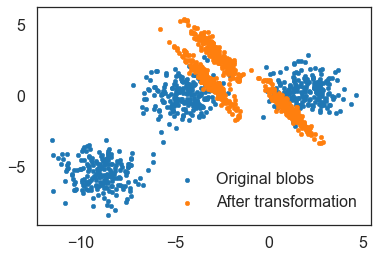

In [29]:
X, y = make_blobs(random_state=170, n_samples=600)
rng = np.random.RandomState(74)
plt.scatter(X[:, 0], X[:, 1], s=20, label="Original blobs")
transformation = rng.normal(size=(2, 2))
X = np.dot( X, transformation)
plt.scatter(X[:, 0], X[:, 1], s=20, label="After transformation")
plt.legend()
X0 = X.copy()   # Useful later on

Create the clustering using the expected three clusters.

0.58673639123840438

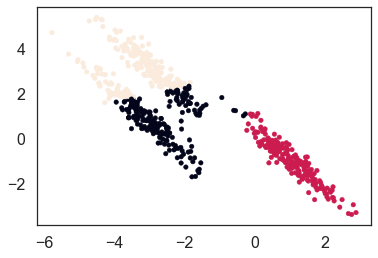

In [30]:
y_pred = KMeans(n_clusters=3).fit_predict(X)

plt.scatter(X[:, 0], X[:, 1], c=y_pred, s=20)
adjusted_rand_score(y_pred, y)

### Density-based and hierarchical clustering
There are various clustering algorithms. Here we will investigate two more, that are quite different from k-means and result in different properties of the resulting clusters.

Density based clustering (here we use *DBSCAN*) links up observations that are, together with neighbors locally above a density threshold. Hierarcjical clustering will result in a hiereachy where, when one climbs up the hierarchy links every observatin to all other ones. In a sense, at the lowest level all observations are there own cluster, and at the highest level they are all in one. In between all that, they link up gradually and the lower the level on which they link up, the more 'similar' (or: close) they are.

Try DBSCAN as well as hierarchical agglomerative clustering on X, X1 and X2 above. Don't worry yet about hyperparameters. Note that in dbscan, there amy be noise samples, these have label -1. Comment on the recovered clusters.

In [31]:
from sklearn.cluster import DBSCAN, AgglomerativeClustering

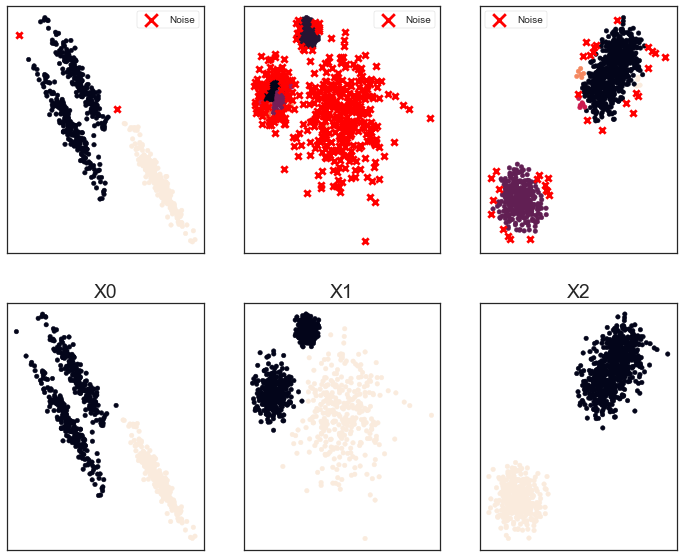

In [32]:
plt.figure(figsize=(12,10))
db = DBSCAN()
for i,x in enumerate([X0, X1, X2]):
    labels = db.fit_predict(x)
    plt.subplot(2,3,i+1)
    plt.scatter(x[labels>=0, 0], x[labels>=0, 1], c= labels[labels>=0], s=20)
    plt.scatter(x[labels == -1, 0], x[labels == -1, 1], c='red', marker='x', s=40, label="Noise")
    plt.xticks([])
    plt.yticks([])
    plt.legend(frameon=True, fontsize=10, markerscale=2 )
    
hier = AgglomerativeClustering()
for i,x in enumerate([X0, X1, X2]):
    labels = hier.fit_predict(x)
    plt.subplot(2,3,i+4)
    plt.scatter(x[:, 0], x[:, 1], c= labels, s=20)
    plt.xticks([])
    plt.yticks([])
    plt.title("X"+str(i))
    

**DBSCAN**:
- X: clusters are recovered fairly well, only quite strongly deviating poiints are considered noise.
- X1: The lowest density cluster is only noise, the medium density is only recovered in its dense core.
- X2: The clusters that touch each other are connected, because the density doesn't go low enough in between them.

In **hierachical clustering**, the result is not just the label that it assigns, but also the full tree that it creates, based on extra hyperparameters. By default, some choices have been made about predicted labels. ONe of those choices is the number of clusters (2) Results are less sensitive to local density, but depend more on the distance to neighbors. The dendrogram shows the full structure. The dendromgram isn't specific to the clustering algorithm, but you will have to look at that linkage and distance metrics. 

Try playing with the hyperparameters to see if you can get either of the algorithms to give you something desirable.

Create three blobs, with a total of 30 points, all the rest default. Import linkage and dendrogram from sklearn.cluster.hierarchy and run both the dendrogram and clustering. Compare! You can run it a few times with different random number states for the creation of the blobs (specifiying none will get you a different seed everytime).

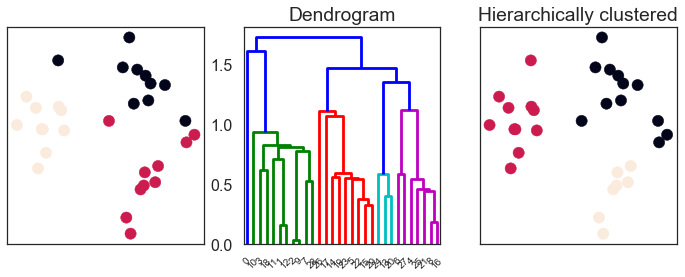

In [33]:
from scipy.cluster.hierarchy import dendrogram, linkage

X, y = make_blobs(n_samples=30, centers=3, random_state=0)

Z = linkage(X)
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.scatter(X[:,0], X[:,1], c=y)
plt.xticks([])
plt.yticks([])


plt.subplot(132)
dendrogram(Z, count_sort=True);
plt.title('Dendrogram')

plt.subplot(133)
hier = AgglomerativeClustering(n_clusters=3)
labels = hier.fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c= labels)
plt.xticks([])
plt.yticks([])
plt.title('Hierarchically clustered');

### How many clusters to use?
Except when you use DBSCAN (or any other Friends-of-Friends-like algorithm), the number of clusters is something you need to specify. In density-based clustering there are similar, denisty-related, free parameters you need to set by hand. There may be a reason for you to pick a value (based on the context of the clustering exercise, or based on your visualizations), but there are also some qualitative figures you may want try. A note of caution though: pretty much none of the existing "rules of thumb" are definitive. After StandardScaler, there are some relatively well working defaults for DBSCAN.

Let's have a look. The 'elbow' method is a way to $<$handwavy description$>$ estimate the gain of "information" when increasing the number of clusters, such that the addition of clusters isn't redundant $<$/handwavy description$>$. The attribute of a k-means instance inertia\_, that exists after fitting is: "Sum of distances of samples to their closest cluster center." This won't ever be minimized by the addition of more cluster centers, but the addition of more cluster centers won't help much when you are at more cluster centers than you need. Try it out on a data set with 4 well separated clusters. After that, try less well separated clusters, like X2, above.

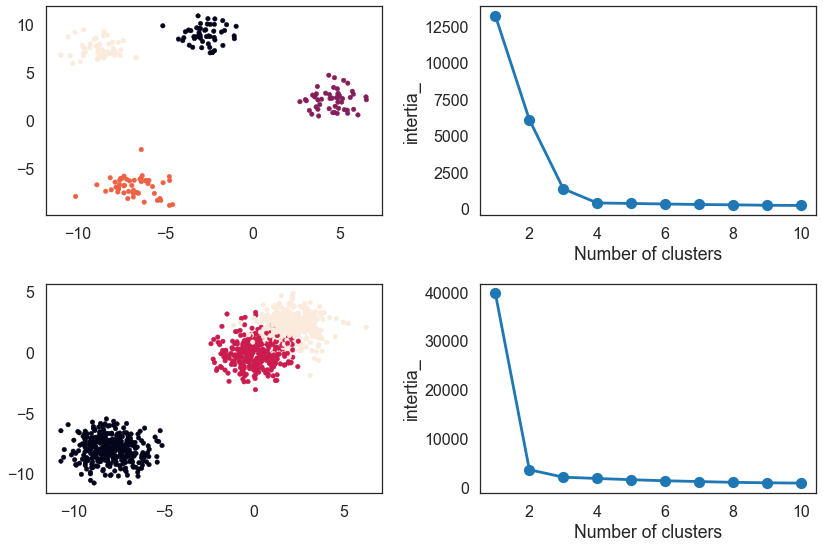

In [34]:
X, y = make_blobs(n_samples=200, centers=4, random_state=42)
plt.figure(figsize=(12,8))
plt.subplot(221)
plt.scatter(X[:,0], X[:,1], c=y, s=20)

plt.subplot(222)
inertia = []
for i in range(1, 11):
    km = KMeans(n_clusters=i, 
                random_state=0)
    km.fit(X)
    inertia.append(km.inertia_)
plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('intertia_')
plt.tight_layout()


plt.subplot(223)
plt.scatter(X2[:,0], X2[:,1], c=y2, s=20)

plt.subplot(224)
inertia = []
for i in range(1, 11):
    km = KMeans(n_clusters=i, 
                random_state=0)
    km.fit(X2)
    inertia.append(km.inertia_)
plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('intertia_')
plt.tight_layout()



Density based clustering gives you the opportunity to say something quantitativily meaningful aout what to call clusters and what not to call clusters. Given that the dimensions of the features have some "physical" meaning, a density does, too. Now one axis may be difficult to compare to the other, but after scaling, you're guaranteed (unless your data really is not suitable for standard scaling; in which cases taking a log first often helps...) that along any axis *a distance of 1 means that two data points are one standarda deviation apart*, which has at least statistical meaning.

Common practice is to stick to setting the epsilon parameter of DBSCAN to 0.5. Some people, rightfully, argue a value that depends on the number of dimensions (and perhaps even the number of data points), but as it turns out, 0.5 often just works fairly well. Try this on the same data up here, where cluster finding seemed troublesome.

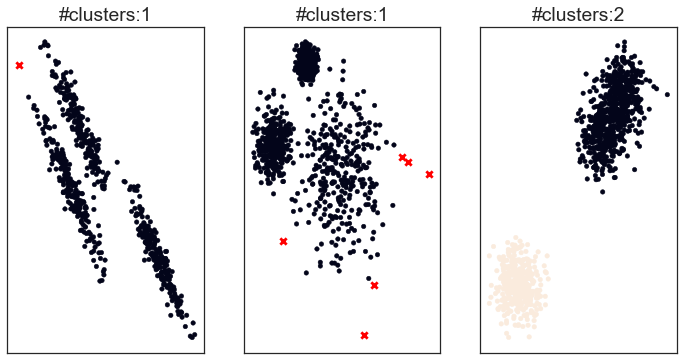

In [35]:
# from sklearn.preprocessing import StandardScaler
plt.figure(figsize=(12,6))
for i, dat in enumerate([X0, X1, X2]):
    x = StandardScaler().fit_transform(dat)
    labels = DBSCAN(eps=0.5).fit_predict(x)
    plt.subplot(1,3,i+1)
    plt.scatter(x[labels>=0, 0], x[labels>=0, 1], c= labels[labels>=0], s=20)
    plt.scatter(x[labels == -1, 0], x[labels == -1, 1], c='red', marker='x', s=40, label="Noise")
    plt.xticks([])
    plt.yticks([])
    plt.title("#clusters:"+str(labels.max()+1))


Always be aware of them damn bridges! NOw does this all make sense? Downsample the observations and you might be in for a surprise...

### Bonus exercise: clustering in higher-dimensional spaces

- Can you get the three types of flowers in the iris data set recovered using clustering techniques?
- Try blobs in very many dimensions and see if you can get them to recover well. Does dimensionality reduction first help?

Shape of features: (150, 4)


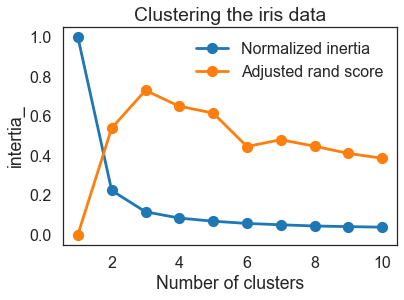

In [36]:
iris = load_iris()
X = iris.data
y = iris.target

print("Shape of features:", X.shape)
inertia = []
scores = []
for i in range(1, 11):
    km = KMeans(n_clusters=i, 
                random_state=0)
    labels = km.fit_predict(X)
    inertia.append(km.inertia_)
    scores.append(adjusted_rand_score(y, labels))
plt.plot(range(1, 11), np.array(inertia)/np.max(inertia), marker='o', label="Normalized inertia")
plt.plot(range(1, 11), scores, marker='o', label='Adjusted rand score')
plt.legend()
plt.xlabel('Number of clusters')
plt.ylabel('intertia_')
plt.title("Clustering the iris data");



It is not very clear from the inertia alone what number of clusters to use, but together with the adjusted rand score together, three is likely the best choice. That rand score, though, is only known if the problem at hand is not actually unsupervised: you need the "real labels" for it. 
After PCA, a nice feature is that you can get to similar ersults using only one variable. This can help a lot in very high-dimensional data sets:

Shape of features: (150, 1)


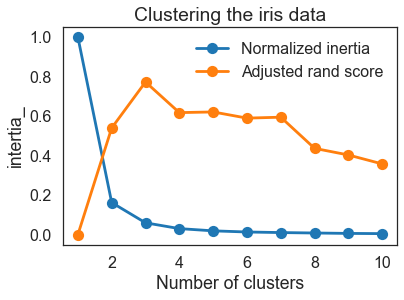

In [37]:
Xp = pca.fit_transform(X)[:,:1]
print("Shape of features:", Xp.shape)
inertia = []
scores = []
for i in range(1, 11):
    km = KMeans(n_clusters=i, 
                random_state=0)
    labels = km.fit_predict(Xp)
    inertia.append(km.inertia_)
    scores.append(adjusted_rand_score(y, labels))
plt.plot(range(1, 11), np.array(inertia)/np.max(inertia), marker='o', label="Normalized inertia")
plt.plot(range(1, 11), scores, marker='o', label='Adjusted rand score')
plt.legend()
plt.xlabel('Number of clusters')
plt.ylabel('intertia_')
plt.title("Clustering the iris data");



In [38]:
# %%timeit
X, y = make_blobs(n_features=100, centers=4, n_samples=100000)
inertia = []
scores = []
for i in range(1, 11):
    km = KMeans(n_clusters=i, 
                random_state=0)
    labels = km.fit_predict(X)
    inertia.append(km.inertia_)
    scores.append(adjusted_rand_score(y, labels))

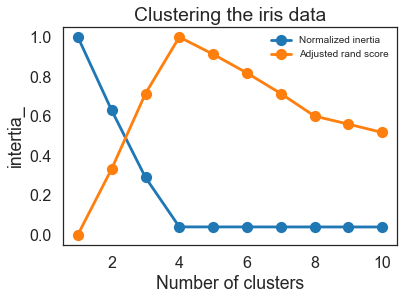

In [39]:
plt.plot(range(1, 11), np.array(inertia)/np.max(inertia), marker='o', label="Normalized inertia")
plt.plot(range(1, 11), scores, marker='o', label='Adjusted rand score')
plt.legend(fontsize=10)
plt.xlabel('Number of clusters')
plt.ylabel('intertia_')
plt.title("Clustering the iris data");

In [40]:
# %%timeit
Xp = pca.fit_transform(X)[:,:3]
inertia = []
scores = []
for i in range(1, 11):
    km = KMeans(n_clusters=i, 
                random_state=0)
    labels = km.fit_predict(Xp)
    inertia.append(km.inertia_)
    scores.append(adjusted_rand_score(y, labels))



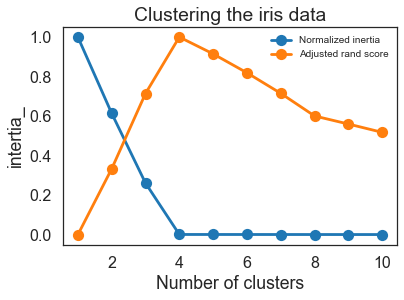

In [41]:
plt.plot(range(1, 11), np.array(inertia)/np.max(inertia), marker='o', label="Normalized inertia")
plt.plot(range(1, 11), scores, marker='o', label='Adjusted rand score')
plt.legend(fontsize=10)
plt.xlabel('Number of clusters')
plt.ylabel('intertia_')
plt.title("Clustering the iris data");
